In [2]:
import sys
sys.path.insert(1, '/home/jovyan/home/tools')

In [3]:
from abg_python.snapshot_utils import openSnapshot
from abg_python.cosmo_utils import load_AHF
import numpy as np
import matplotlib.pyplot as plt

Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities


In [4]:
baseDir = '/home/jovyan/fire2/AGN_suite'
AGNSims_push = [
    'm13h206_m3e5/m13h206_m3e5_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1',
    'm13h29_m3e5/m13h29_m3e5_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp5e-3_mw4e-7_fa0.5_tw1e4_fmom1',
    'm12f_m6e4/m12f_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp8e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12i_m6e4/m12i_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12q_m6e4/m12q_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1'
]
AGNSims_jet = [
    'm13h206_m3e5/m13h206_m3e5_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1',
    'm12f_m6e4/m12f_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp8e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12i_m6e4/m12i_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12q_m6e4/m12q_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1'
]
AGNSims_spawn = [
    'm13h206_m3e5/m13h206_m3e5_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1',
    'm12f_m6e4/m12f_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp8e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12i_m6e4/m12i_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1',
    'm12q_m6e4/m12q_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1'
]

AGNSims_all = AGNSims_push + AGNSims_jet
AGNSims_m13 = [s for s in AGNSims_all if 'm13' in s]
AGNSims_m12 = [s for s in AGNSims_all if 'm12' in s]

In [5]:
def inrange(a, ra):
    a1, a2 = ra
    return (a1 <= a)&(a <= a2)

In [29]:
def center(p0):
    pos_max_density = p0['Coordinates'][np.argmax(p0['Density'])]
    return pos_max_density, 2000

In [34]:
def load_p0(simName, snapnum):
    p0 = openSnapshot(f'{baseDir}/{simName}/output', snapnum, 0, loud=1)
    
    print(f"Loading redshift {p0['Redshift']}")

    #posC, Rvir = load_AHF('', snapnum, p0['Redshift'], hubble=p0['HubbleParam'], ahf_path=f'/projects/b1026/halo_files/anglesd_m13/{simName}', extra_names_to_read=[])
    posC, Rvir = center(p0)

    # position relative to center
    p0['CoordinatesRelative'] = p0['Coordinates'] - posC

    # distance from halo center
    p0['r'] = np.linalg.norm(p0['CoordinatesRelative'], axis=1)

    # distance from halo center in units of virial radius
    p0['r_scaled'] = p0['r']/Rvir

    # volume of each particle
    p0['Vi'] = p0['Masses']/p0['Density']
    
    return p0

In [36]:
def data_allsims_gen(snapnum, simarray):
    data_allsims = {}
    for simName in simarray:
        p0 = load_p0(simName, snapnum)
        rmid, logTavgbins = logTavgGen(p0)
        data_allsims[simName]= (p0, rmid, logTavgbins)
    return data_allsims

In [47]:
def plot_allsims(data_allsims, z_round2):
    plt.figure(dpi=200)

    for simName, (p0, rmid, logTavgbins) in data_allsims.items():
        plt.plot(np.log10(rmid), logTavgbins, '.', label=simName.split('/')[1].split('_alpha')[0])
        assert np.round(p0["Redshift"], 2) == z_round2

    plt.xlabel(r'$\log (r/R_{vir})$')
    plt.ylabel(r'$\left<\log \left(T/\mathrm{K}\right)\right>$')
    plt.legend()
    plt.title(f'$z={np.round(p0["Redshift"],2)}$')
    
    # chosen for z=1.0 and z=1.1 for both plot_allsims and Stern_comparison
#     plt.xlim(-2.4076934712894045, 0.4207781206510557)
#     plt.ylim(5.256989216804504, 7.472256517410278)

In [42]:
def Stern_comparison(data_allsims, simTag='h2'):
    p0, rmid, logTavgbins = data_allsims[simTag]

    plt.figure(dpi=200)
    plt.plot(np.log10(rmid), logTavgbins, '.', label=f'{simTag}_{officialSimNames[simTag]}{simNameBase}')

    x_fid,y_fid = np.loadtxt('Stern20_Fig6_m13A8_Tavg_z1.1.csv', delimiter=',').T
    plt.plot(np.log10(x_fid),np.log10(y_fid), label='Stern+20 m13A8 z=1.1 (Fig. 6)', c='#e57058')

    plt.xlabel(r'$\log (r/R_{vir})$')
    plt.ylabel(r'$\left<\log \left(T/\mathrm{K}\right)\right>$')
    plt.legend()
    plt.title(f'$z={np.round(p0["Redshift"],2)}$')
    
    # same as plot_allsims
    plt.xlim(-2.4076934712894045, 0.4207781206510557)
    plt.ylim(5.256989216804504, 7.472256517410278)

In [9]:
#Tmask = True#p0['Temperature'] >= 1e5

# z=1

## AGN feedback runs

In [43]:
data_m12sims_45 = data_allsims_gen(45, AGNSims_m12)

/home/jovyan/fire2/AGN_suite/m12f_m6e4/m12f_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp8e-4_mw1e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.0000000000006244
/home/jovyan/fire2/AGN_suite/m12i_m6e4/m12i_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.0000000000006244
/home/jovyan/fire2/AGN_suite/m12q_m6e4/m12q_m6e4_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp7e-4_mw1e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.0000000000087703
/home/jovyan/fire2/AGN_suite/m12f_m6e4/m12f_m6e4_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp8e-4_mw1e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redsh

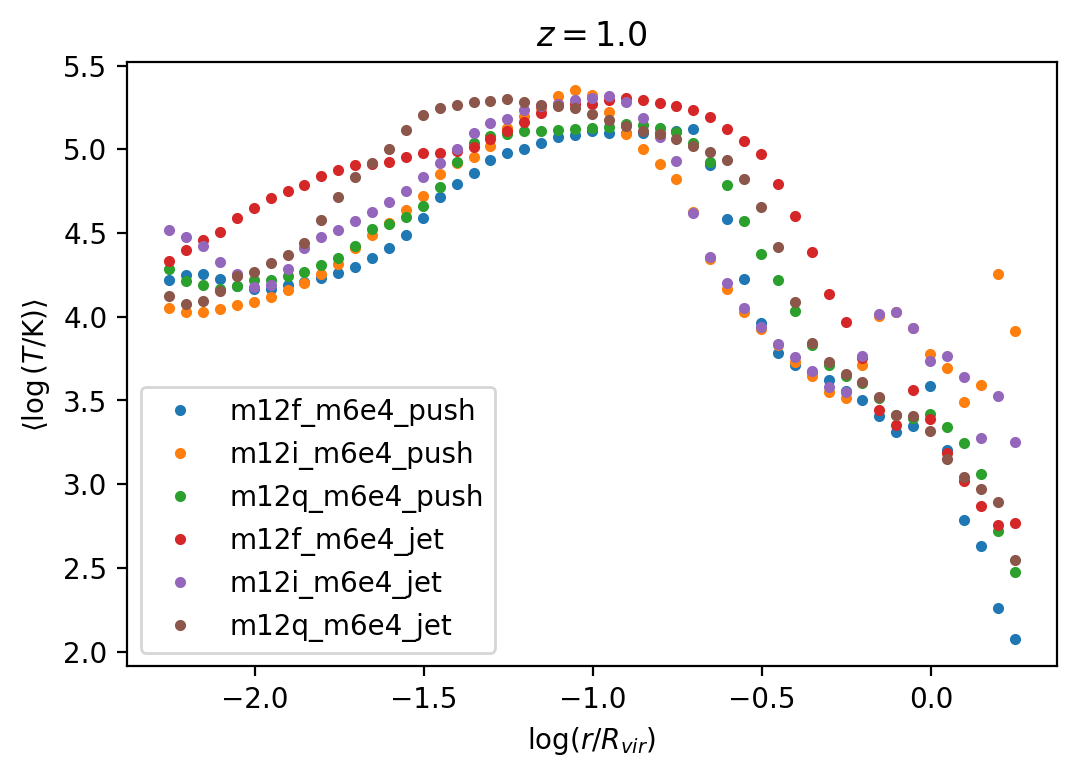

In [48]:
plot_allsims(data_m12sims_45, 1.0)

In [49]:
data_m13sims_37 = data_allsims_gen(37, AGNSims_m13)

/home/jovyan/fire2/AGN_suite/m13h206_m3e5/m13h206_m3e5_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1/output/snapshot_037.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.7999996640070286
/home/jovyan/fire2/AGN_suite/m13h29_m3e5/m13h29_m3e5_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp5e-3_mw4e-7_fa0.5_tw1e4_fmom1/output/snapshot_037.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.799999664018022
/home/jovyan/fire2/AGN_suite/m13h206_m3e5/m13h206_m3e5_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1/output/snapshot_037.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 1.7999996640070286


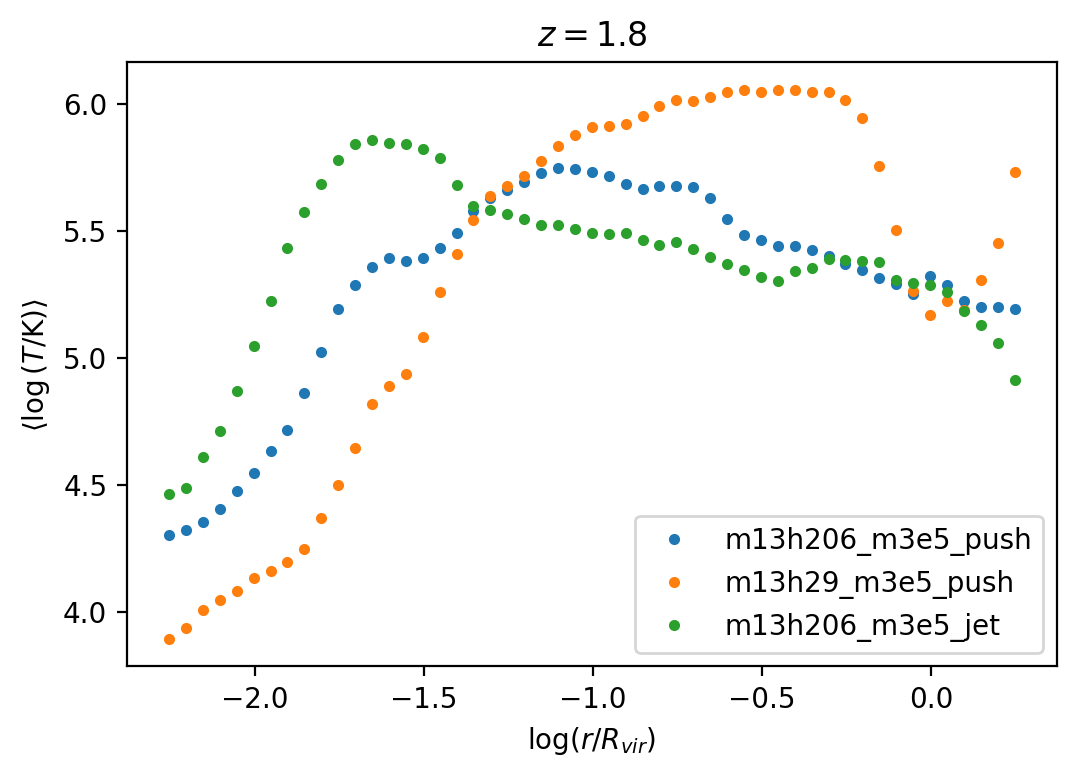

In [50]:
plot_allsims(data_m13sims_37, 1.8)

In [54]:
data_m13sims_45 = data_allsims_gen(45, [AGNSims_m13[0],AGNSims_m13[2]])

/home/jovyan/fire2/AGN_suite/m13h206_m3e5/m13h206_m3e5_push_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 0.9999999999999996
/home/jovyan/fire2/AGN_suite/m13h206_m3e5/m13h206_m3e5_jet_alpha10_gacc30_accf1_vw10000_cr1e-2_msd1e-8_sdp3e-3_mw4e-7_fa0.5_tw1e4_fmom1/output/snapshot_045.hdf5
This is a cosmological snapshot... converting to physical units
Loading redshift 0.9999999999999996


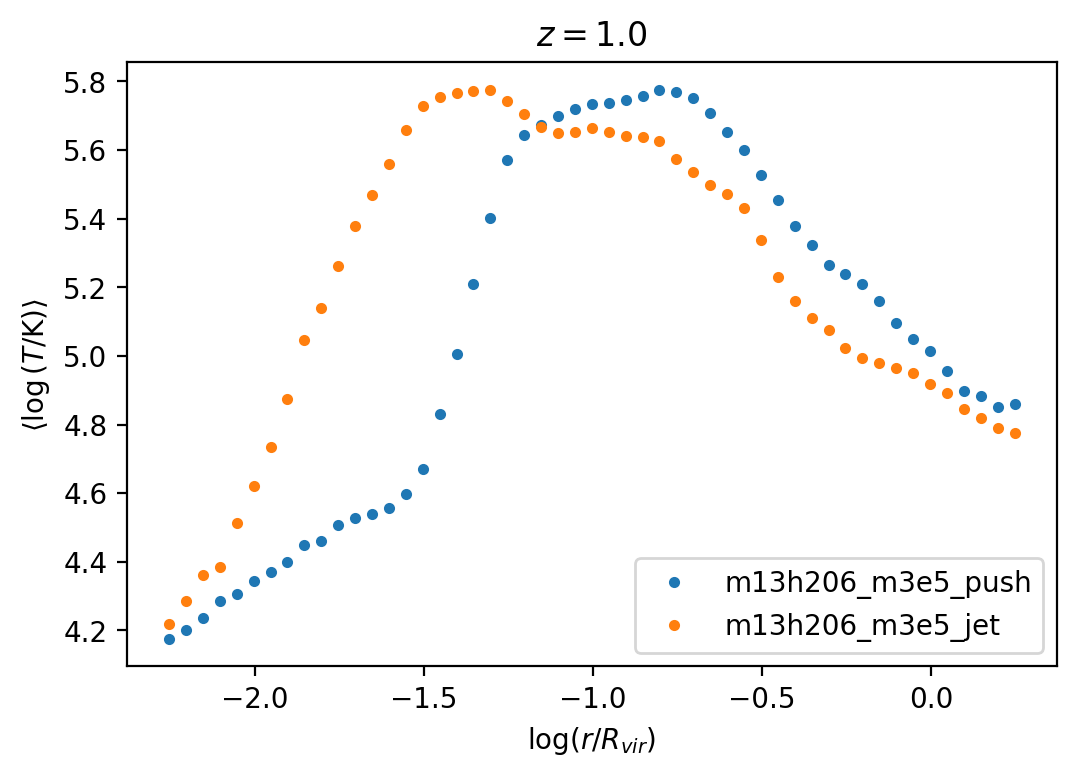

In [55]:
plot_allsims(data_m13sims_45, 1.0)

## No-feedback runs

In [10]:
data_allsims_277 = data_allsims_gen(277)

/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
Loading redshift 1.0000000007662364
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.4.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277

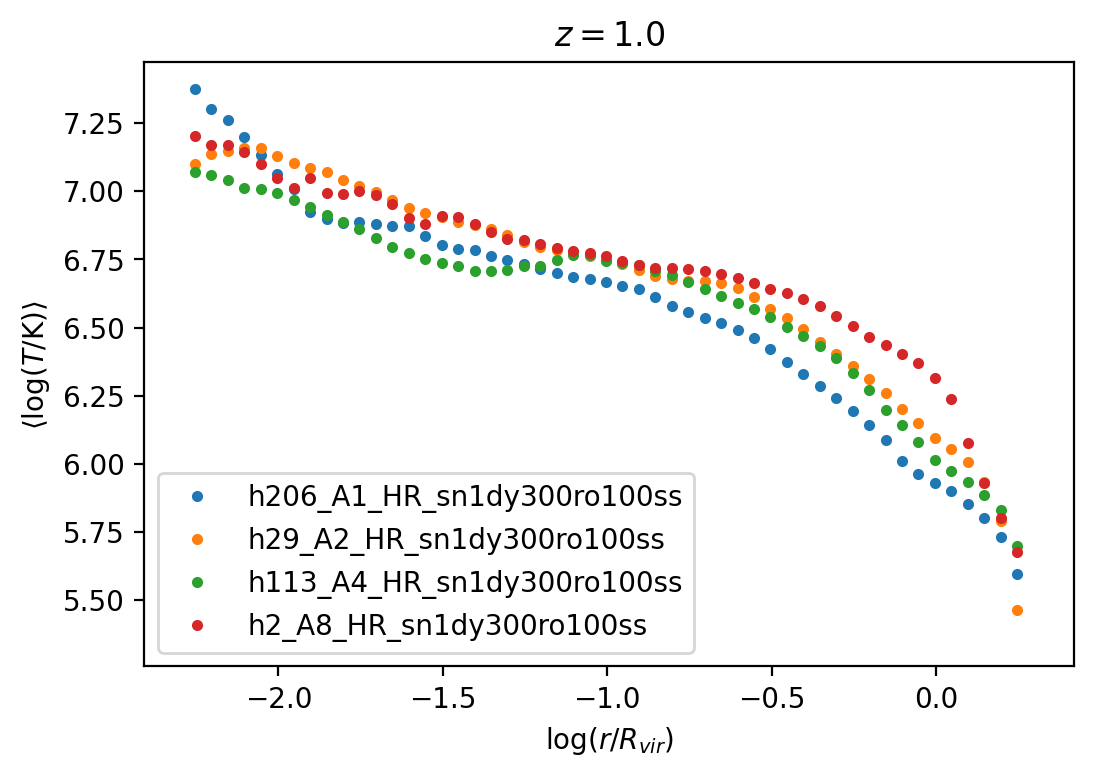

In [43]:
plot_allsims(data_allsims_277, 1.00)
plt.savefig('Figures/Tprofile_allsims_z1.png')

## A8 z=1 comparison with Stern+20 z=1.1

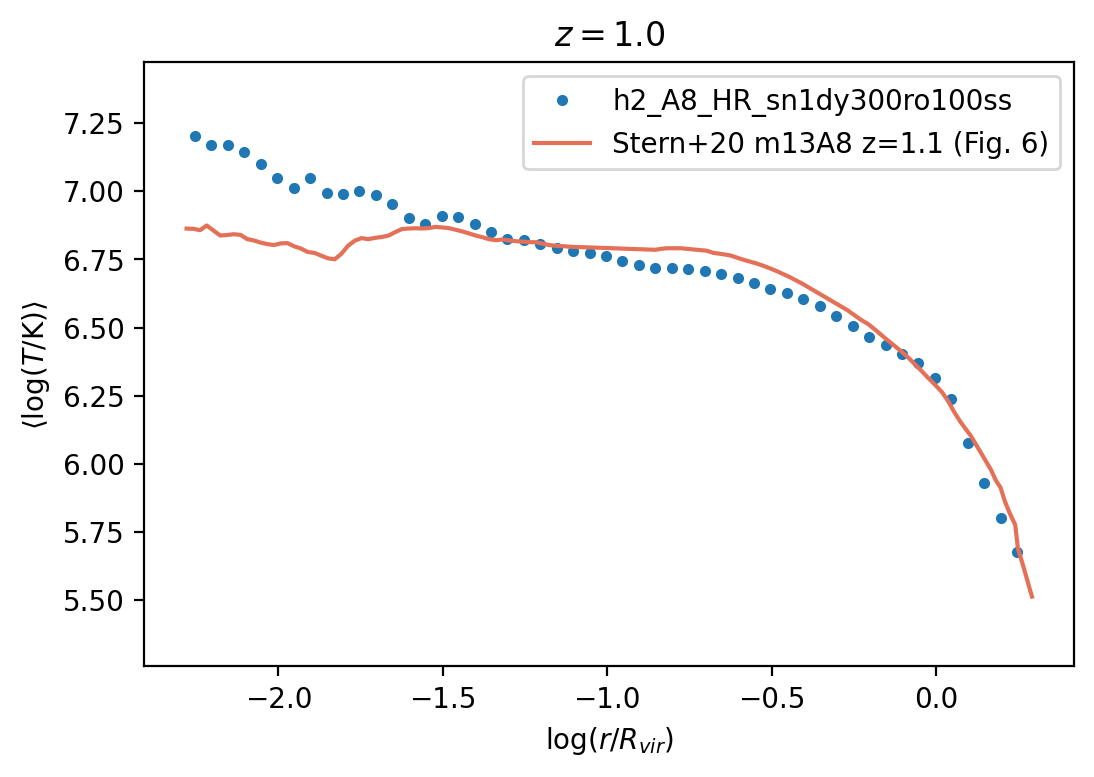

In [44]:
Stern_comparison(data_allsims_277)
plt.savefig('Figures/Tprofile_A8comparison_z1.png')

# z=1.1

## No-feedback runs

In [12]:
data_allsims_262 = data_allsims_gen(262)

/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.1.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.2.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.3.hdf5
Loading redshift 1.0999998958284714
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.1.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.2.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.3.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.4.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262

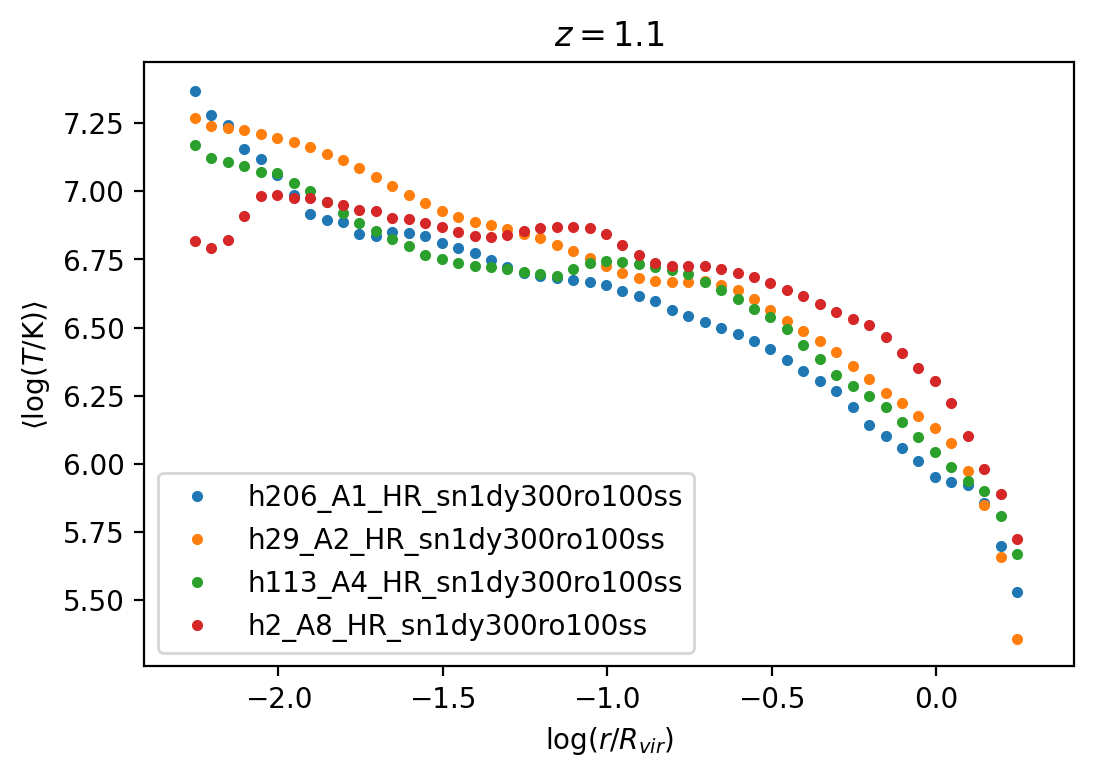

In [45]:
plot_allsims(data_allsims_262, 1.10)
plt.savefig('Figures/Tprofile_allsims_z1_1.png')

## A8 z=1.1 comparison with Stern+20 z=1.1

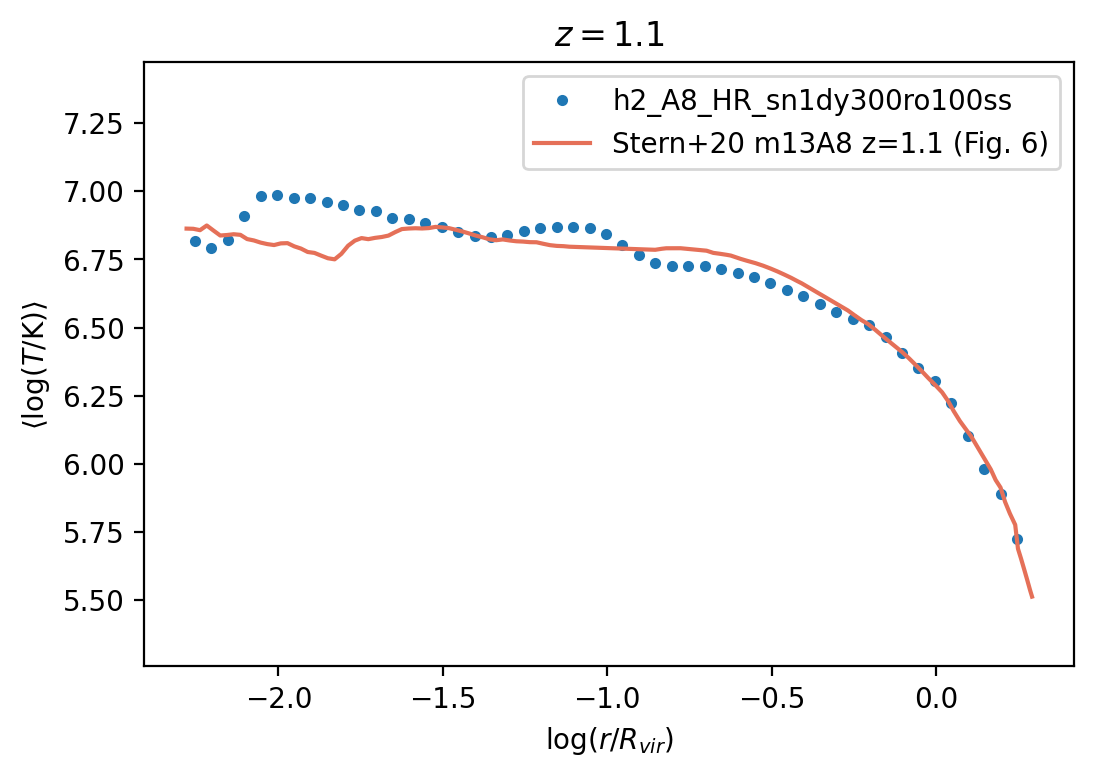

In [46]:
Stern_comparison(data_allsims_262)
plt.savefig('Figures/Tprofile_A8comparison_z1_1.png')